<a href="https://colab.research.google.com/github/iamnelsonizah/Computer-Vision-Projects-with-Python/blob/main/Airpolution_Covid19_(Nitrogen).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import ee
import geemap
import xarray as xr
from google.colab import auth
import matplotlib.pyplot as plt

In [2]:
!pip install xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.4 MB/s eta 0:00:00


In [29]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-nelsonizah',
    opt_url='https://earthengine-highvolume.googleapis.com'
)

In [5]:
map = geemap.Map(basemap = "TERRAIN")
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [30]:
roi = map.draw_last_feature.geometry()

In [31]:
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          436.665344,
                          43.022722
                        ],
                        [
                          436.665344,
                          43.419014
                        ],
                        [
                          437.178955,
                          43.419014
                        ],
                        [
                          437.178955,
                          43.022722
                        ],
                        [
                          436.665344,
                          43.022722
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [32]:
nitrogen = (
    ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2")
    .filterDate('2018', '2025')
    .filterBounds(roi)
    .select(['NO2_column_number_density'],['no2'])
)

nitrogen.first()


In [33]:
ds = xr.open_dataset(
    nitrogen,
    engine='ee',
    crs='epsg:4326',
    scale = 0.1,
    geometry = roi
    # chunks={'time': 1}
)


In [34]:
ds

<xarray.Dataset> Size: 504kB
Dimensions:  (time: 5721, lon: 5, lat: 4)
Coordinates:
  * time     (time) datetime64[ns] 46kB 2018-07-12T06:49:08 ... 2024-12-30T08...
  * lon      (lon) float64 40B 76.72 76.82 76.92 77.02 77.12
  * lat      (lat) float64 32B 43.07 43.17 43.27 43.37
Data variables:
    no2      (time, lon, lat) float32 458kB ...
Attributes: (12/19)
    date_range:               [1531180800000, 1647907200000]
    description:              <h3 id="nrtil3_no2">NRTI/L3_NO2</h3><p>This dat...
    keywords:                 ['air_quality', 'copernicus', 'esa', 'eu', 'knm...
    period:                   0
    product_tags:             ['tropomi', 'no2', 'nitrogen_dioxide', 'polluti...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    tropospheric_NO2_column_number_density
    visualization_0_max:      0.0002
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      epsg:4326

In [35]:
annual = ds.resample(time='YE').mean('time')
annual

<xarray.Dataset> Size: 688B
Dimensions:  (time: 7, lon: 5, lat: 4)
Coordinates:
  * lon      (lon) float64 40B 76.72 76.82 76.92 77.02 77.12
  * lat      (lat) float64 32B 43.07 43.17 43.27 43.37
  * time     (time) datetime64[ns] 56B 2018-12-31 2019-12-31 ... 2024-12-31
Data variables:
    no2      (time, lon, lat) float32 560B 8.882e-05 0.0001649 ... 0.0001746
Attributes: (12/19)
    date_range:               [1531180800000, 1647907200000]
    description:              <h3 id="nrtil3_no2">NRTI/L3_NO2</h3><p>This dat...
    keywords:                 ['air_quality', 'copernicus', 'esa', 'eu', 'knm...
    period:                   0
    product_tags:             ['tropomi', 'no2', 'nitrogen_dioxide', 'polluti...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    tropospheric_NO2_column_number_density
    visualization_0_max:      0.0002
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      epsg:4326

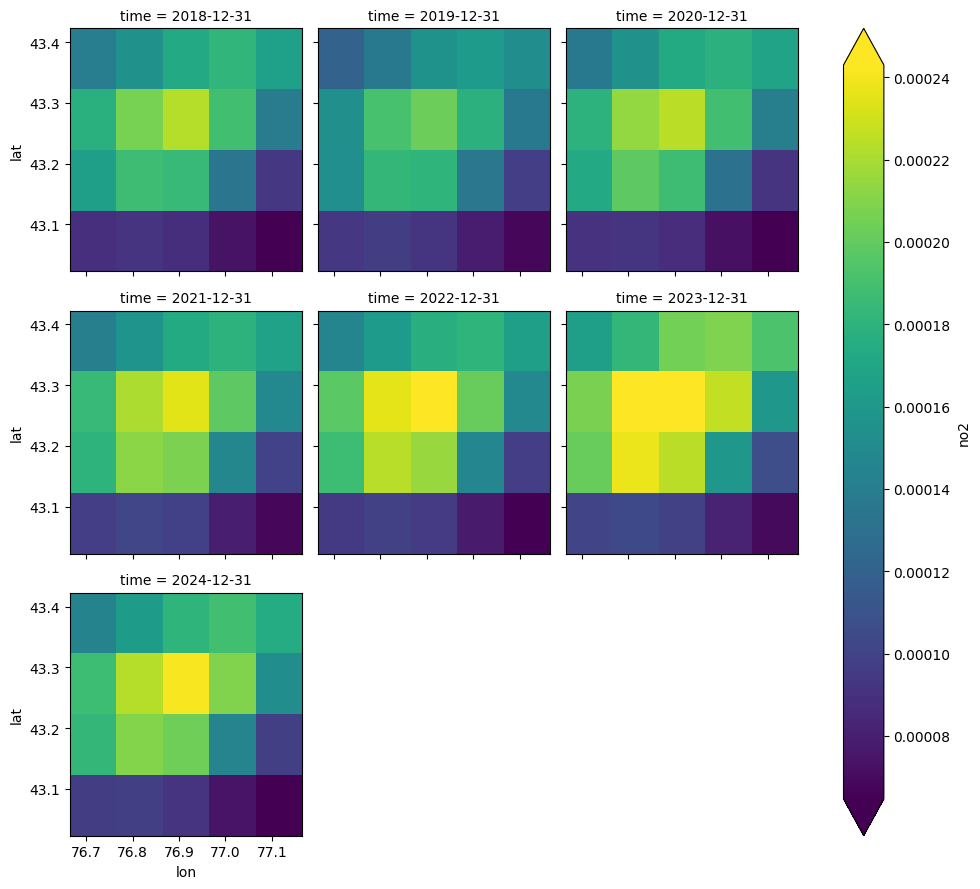

In [41]:
annual.no2.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 3,
    robust = True
)
plt.savefig('annual_no2.png', dpi=360, bbox_inches='tight')

In [43]:
annual_mean = annual.mean(dim = ['lon', 'lat'])
annual_mean

<xarray.Dataset> Size: 84B
Dimensions:  (time: 7)
Coordinates:
  * time     (time) datetime64[ns] 56B 2018-12-31 2019-12-31 ... 2024-12-31
Data variables:
    no2      (time) float32 28B 0.0001458 0.0001383 ... 0.0001723 0.0001562

In [44]:
annual_df = annual_mean.to_dataframe()
annual_df

,no2
time,
2018-12-31,0.000146
2019-12-31,0.000138
2020-12-31,0.000147
2021-12-31,0.000155
2022-12-31,0.000158
2023-12-31,0.000172
2024-12-31,0.000156


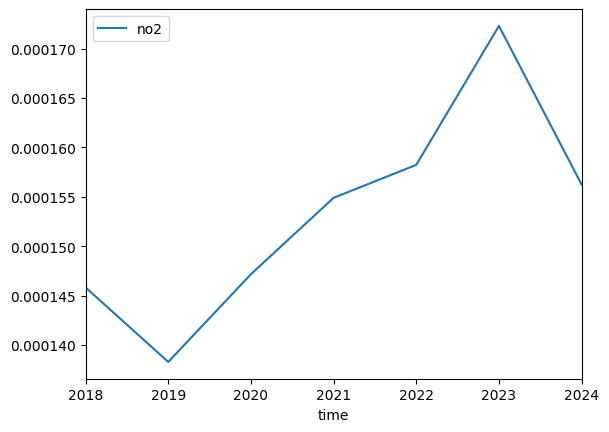

In [45]:
annual_df.plot()
plt.savefig('annual_mean.png', dpi=360, bbox_inches='tight')

In [46]:
annual_df['annomaly'] = annual_df['no2'] - annual_df['no2'].mean()
annual_df

,no2,annomaly
time,,
2018-12-31,0.000146,-0.000007
2019-12-31,0.000138,-0.000015
2020-12-31,0.000147,-0.000006
2021-12-31,0.000155,0.000002
2022-12-31,0.000158,0.000005
2023-12-31,0.000172,0.000019
2024-12-31,0.000156,0.000003


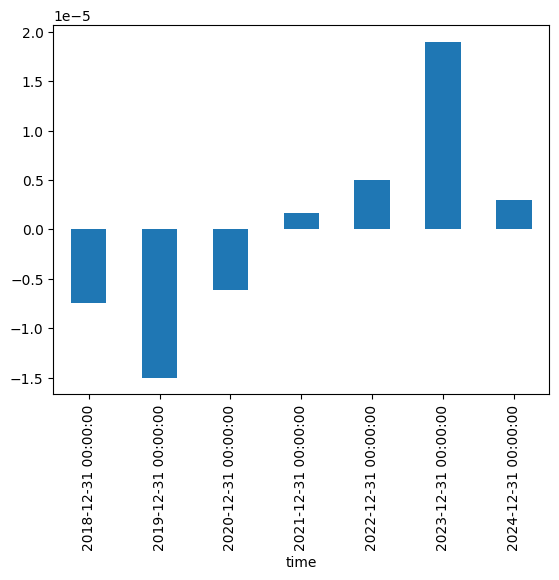

In [57]:
annual_df.annomaly.plot.bar()
plt.savefig('anomaly.png', dpi=360, bbox_inches='tight')

In [60]:
annual_df['pct'] = annual_df.no2.pct_change()
annual_df

,no2,annomaly,pct_change,pct
time,,,,
2018-12-31,0.000146,-0.000007,NaN,NaN
2019-12-31,0.000138,-0.000015,-0.051670,-0.051670
2020-12-31,0.000147,-0.000006,0.064181,0.064181
2021-12-31,0.000155,0.000002,0.052521,0.052521
2022-12-31,0.000158,0.000005,0.021531,0.021531
2023-12-31,0.000172,0.000019,0.088851,0.088851
2024-12-31,0.000156,0.000003,-0.093159,-0.093159


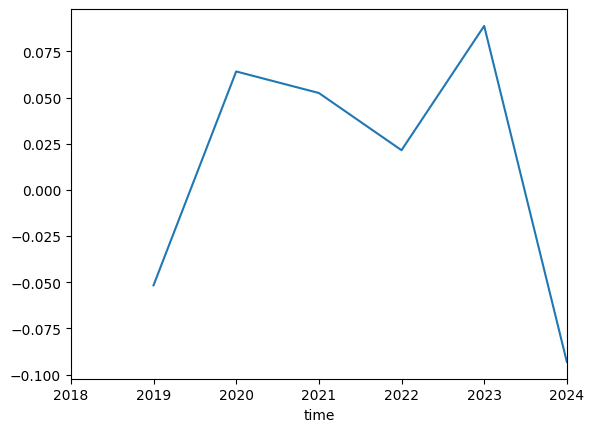

In [61]:
annual_df.pct.plot()
plt.savefig('pct_change.png', dpi=360, bbox_inches='tight')

In [48]:
monthly = ds.resample(time='M').mean('time')
monthly

<xarray.Dataset> Size: 7kB
Dimensions:  (time: 78, lon: 5, lat: 4)
Coordinates:
  * lon      (lon) float64 40B 76.72 76.82 76.92 77.02 77.12
  * lat      (lat) float64 32B 43.07 43.17 43.27 43.37
  * time     (time) datetime64[ns] 624B 2018-07-31 2018-08-31 ... 2024-12-31
Data variables:
    no2      (time, lon, lat) float32 6kB 8.903e-05 0.0001118 ... 0.0004054
Attributes: (12/19)
    date_range:               [1531180800000, 1647907200000]
    description:              <h3 id="nrtil3_no2">NRTI/L3_NO2</h3><p>This dat...
    keywords:                 ['air_quality', 'copernicus', 'esa', 'eu', 'knm...
    period:                   0
    product_tags:             ['tropomi', 'no2', 'nitrogen_dioxide', 'polluti...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    tropospheric_NO2_column_number_density
    visualization_0_max:      0.0002
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      epsg:4326

In [49]:
monthly_mean = monthly.mean(dim = ['lon', 'lat'])
monthly_df = monthly_mean.to_dataframe()
monthly_df

,no2
time,
2018-07-31,0.000102
2018-08-31,0.000100
2018-09-30,0.000114
2018-10-31,0.000124
2018-11-30,0.000171
...,...
2024-08-31,0.000107
2024-09-30,0.000109
2024-10-31,0.000132


In [51]:
monthly2020 = monthly_df[monthly_df.index.year == 2020]
monthly2020

,no2
time,
2020-01-31,0.000247
2020-02-29,0.000197
2020-03-31,0.000133
2020-04-30,0.000084
2020-05-31,0.000085
2020-06-30,0.000095
2020-07-31,0.000087
2020-08-31,0.000093
2020-09-30,0.000108


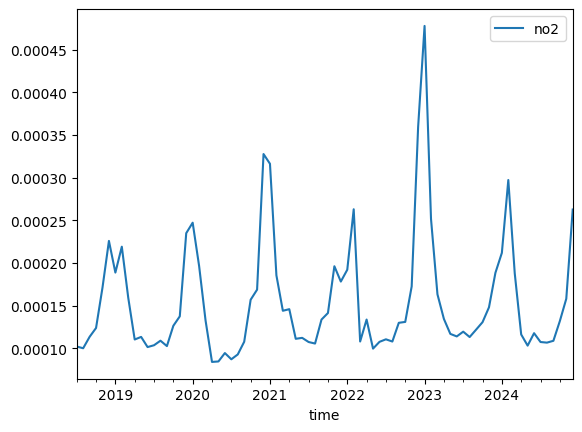

In [50]:
monthly_df.plot()
plt.savefig('monthly_mean.png', dpi=360, bbox_inches='tight')

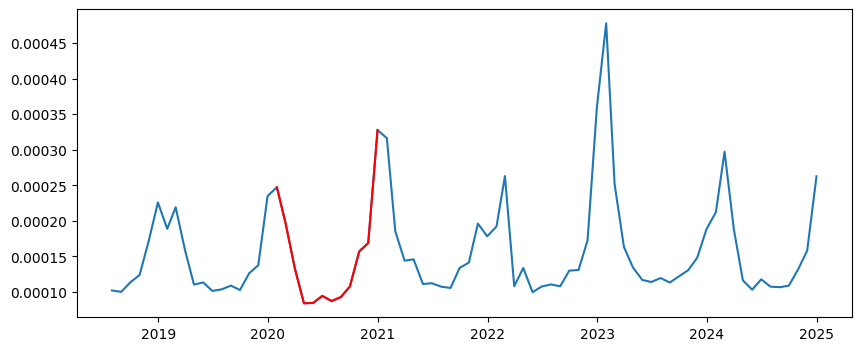

In [53]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    monthly_df.index,
    monthly_df.no2,
)

ax.plot(
    monthly2020.index,
    monthly2020.no2,
    color = 'red'
)